### Imports and Libraries
Import required libraries for data handling, machine learning, evaluation metrics, and visualization.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

### Load Reddit depression dataset
Mount Google Drive and read the cleaned depression dataset into a pandas DataFrame.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

csv_path = "/content/drive/MyDrive/MS/1st Sem/NLP/Data/depression_dataset_reddit_cleaned.csv"

df = pd.read_csv(csv_path)

df.head()

df.columns

Mounted at /content/drive


Index(['clean_text', 'is_depression'], dtype='object')

### Data Selection & Renaming

- Select only the text and label columns from the dataset.
- Remove rows with missing values.
- Rename columns to standardized names (`text`, `label`) for consistency in later models.

In [3]:
text_col  = "clean_text"
label_col = "is_depression"

df = df[[text_col, label_col]].dropna()

df.rename(columns={text_col: "text", label_col: "label"}, inplace=True)

df.head()

,text,label
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [4]:
df["label"].value_counts()

,count
label,
0,3900
1,3831


**Label normalization:**  
Map textual labels to binary values (0 = non-depressed, 1 = depressed) and verify class distribution.

In [5]:

label_map = {
    "control": 0,
    "depression": 1,
    "depressed": 1,
    "non-depressed": 0
}

if df["label"].dtype == "object":
    df["label"] = df["label"].map(label_map)

df["label"].value_counts()

,count
label,
0,3900
1,3831


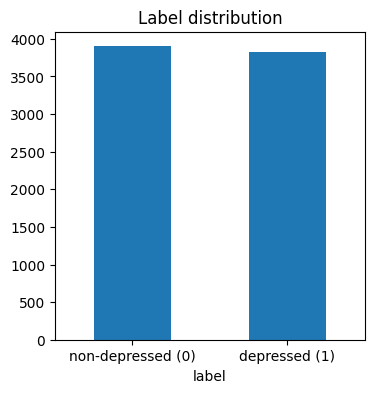

In [6]:
plt.figure(figsize=(4,4))
df["label"].value_counts().plot(kind="bar")
plt.xticks([0,1], ["non-depressed (0)", "depressed (1)"], rotation=0)
plt.title("Label distribution")
plt.show()

In [7]:
df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"].str.len() > 0].reset_index(drop=True)

len(df), df.head(3)

(7731,
                                                 text  label
 0  we understand that most people who reply immed...      1
 1  welcome to r depression s check in post a plac...      1
 2  anyone else instead of sleeping more when depr...      1)

In [8]:
!pip -q install wordcloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

### Word Cloud for Depressed Posts
Generates a word cloud from all posts labeled as depressed to visualize the most frequent and salient terms in depressive language.

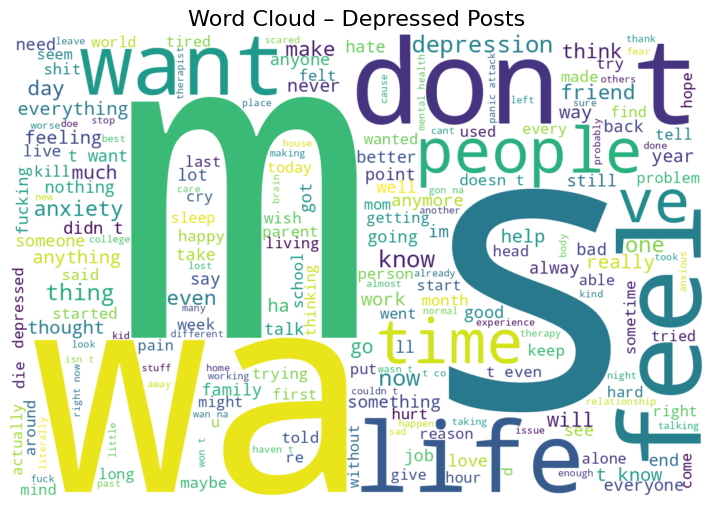

In [9]:
depressed_text = " ".join(df[df["label"] == 1]["text"].astype(str).tolist())

wc_depressed = WordCloud(
    width=1200,
    height=800,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200,
    collocations=True
).generate(depressed_text)

plt.figure(figsize=(10, 6))
plt.imshow(wc_depressed, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Depressed Posts", fontsize=16)
plt.show()

**Word Cloud (Non-Depressed Posts):**  
Creates a word cloud from all posts labeled as *non-depressed* to visualize common terms and language patterns in neutral or positive content.

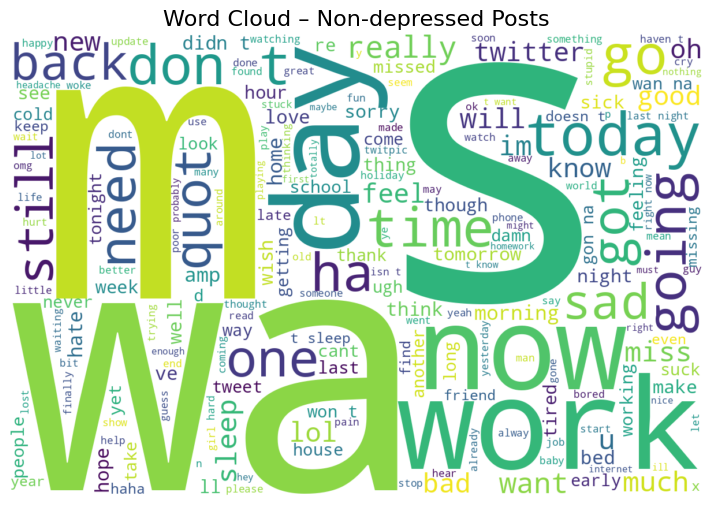

In [10]:
# All non-depressed posts (label == 0)
non_depressed_text = " ".join(df[df["label"] == 0]["text"].astype(str).tolist())

wc_non_dep = WordCloud(
    width=1200,
    height=800,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200,
    collocations=True
).generate(non_depressed_text)

plt.figure(figsize=(10, 6))
plt.imshow(wc_non_dep, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Non-depressed Posts", fontsize=16)
plt.show()

In [11]:
extra_stopwords = {
    "im", "ive", "dont", "cant", "didnt", "doesnt", "really",
    "like", "just", "feel", "feeling", "feelings",
    "reddit", "people", "one", "get", "got"
}

stopwords = STOPWORDS.union(extra_stopwords)

**Train / Validation / Test Split**:


Split the dataset into training, validation, and test sets using stratified sampling to preserve the label distribution across all splits.

In [12]:
X = df["text"].values
y = df["label"].values

# First: train + temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second: split temp into val + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)

(5411, 1160, 1160)

### TF-IDF Feature Extraction
Convert text into numerical features using TF-IDF with unigrams and bigrams for the baseline model.

In [13]:


tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape

((5411, 30000), (1160, 30000), (1160, 30000))

In [14]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

**Validation evaluation (Logistic Regression)**  
Evaluates the TF-IDF + Logistic Regression model on the validation set using accuracy and a detailed classification report.

In [15]:
y_val_pred = log_reg.predict(X_val_tfidf)

print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation report:\n")
print(classification_report(y_val, y_val_pred))

Validation accuracy: 0.9637931034482758

Validation report:

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       585
           1       0.99      0.94      0.96       575

    accuracy                           0.96      1160
   macro avg       0.96      0.96      0.96      1160
weighted avg       0.96      0.96      0.96      1160



### Evaluate Logistic Regression on the test set

In [16]:
y_test_pred = log_reg.predict(X_test_tfidf)

print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest report:\n")
print(classification_report(y_test, y_test_pred))

Test accuracy: 0.9629310344827586

Test report:

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       585
           1       0.99      0.93      0.96       575

    accuracy                           0.96      1160
   macro avg       0.96      0.96      0.96      1160
weighted avg       0.96      0.96      0.96      1160



Plot confusion matrix for TF-IDF + Logistic Regression model.

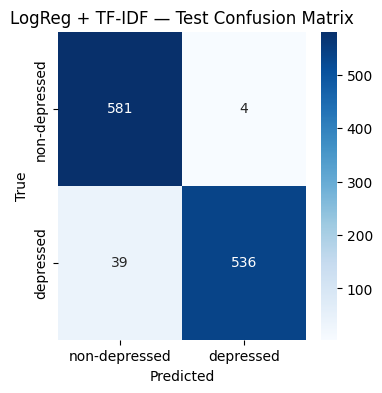

In [17]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["non-depressed", "depressed"],
            yticklabels=["non-depressed", "depressed"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("LogReg + TF-IDF — Test Confusion Matrix")
plt.show()

**Train–Test Split for Transformer Model**

Convert labels to integers and split the dataset into training and test sets (80/20) using stratified sampling to preserve class balance.

In [18]:
!pip -q install transformers datasets accelerate evaluate

import pandas as pd
from sklearn.model_selection import train_test_split

TEXT_COL = "text"
LABEL_COL = "label"

df[LABEL_COL] = df[LABEL_COL].astype(int)

train_df, test_df = train_test_split(
    df[[TEXT_COL, LABEL_COL]],
    test_size=0.2,
    random_state=42,
    stratify=df[LABEL_COL]
)

len(train_df), len(test_df)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00


(6184, 1547)

**Tokenization & Dataset Preparation (DistilBERT)**

Convert the train and test data into Hugging Face Dataset format and tokenize the text using the DistilBERT tokenizer with fixed sequence length. Labels are renamed and datasets are prepared as PyTorch tensors for training.

In [19]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Wrap into HF Dataset objects
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

def tokenize_batch(batch):
    return tokenizer(
        batch[TEXT_COL],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize_batch, batched=True)
test_ds  = test_ds.map(tokenize_batch, batched=True)

# Tell HF which column is the label
train_ds = train_ds.rename_column(LABEL_COL, "labels")
test_ds  = test_ds.rename_column(LABEL_COL, "labels")

train_ds.set_format("torch")
test_ds.set_format("torch")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/6184 [00:00<?, ? examples/s]

Map:   0%|          | 0/1547 [00:00<?, ? examples/s]

### Fine-tune DistilBERT for Depression Classification
Load a pre-trained DistilBERT model, define evaluation metrics (accuracy, precision, recall, F1), and configure the Hugging Face Trainer for supervised fine-tuning on the depression dataset.

In [20]:
import evaluate
import numpy as np
from transformers import (
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy_metric  = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric    = evaluate.load("recall")
f1_metric        = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(predictions=preds, references=labels)
    prec = precision_metric.compute(predictions=preds, references=labels, average="macro")
    rec = recall_metric.compute(predictions=preds, references=labels, average="macro")
    f1 = f1_metric.compute(predictions=preds, references=labels, average="macro")

    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1["f1"],
    }

training_args = TrainingArguments(
    output_dir="./distilbert-depression",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-3836275548.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
train_result = trainer.train()
trainer.save_model("./distilbert-depression-best")

train_result.metrics

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.149900,0.089148,0.971558,0.971775,0.971664,0.971557
2,0.056600,0.075291,0.981254,0.981275,0.981236,0.981252
3,0.030100,0.094177,0.976729,0.976758,0.976782,0.976729


{'train_runtime': 102.1615,
 'train_samples_per_second': 181.595,
 'train_steps_per_second': 11.364,
 'total_flos': 614383794966528.0,
 'train_loss': 0.07887059095910046,
 'epoch': 3.0}

### Fine-tune DistilBERT for depression classification

Test metrics from Trainer: {'test_loss': 0.07529100775718689, 'test_accuracy': 0.9812540400775694, 'test_precision': 0.9812750329314691, 'test_recall': 0.9812364189482834, 'test_f1': 0.9812520346199862, 'test_runtime': 2.5185, 'test_samples_per_second': 614.246, 'test_steps_per_second': 19.456}

Sklearn classification report (DistilBERT):

              precision    recall  f1-score   support

           0     0.9796    0.9833    0.9814       780
           1     0.9830    0.9791    0.9811       767

    accuracy                         0.9813      1547
   macro avg     0.9813    0.9812    0.9813      1547
weighted avg     0.9813    0.9813    0.9813      1547



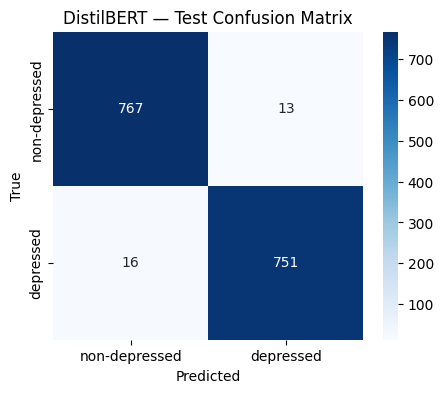

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Get logits for the test set
pred_output = trainer.predict(test_ds)
logits = pred_output.predictions
y_test = pred_output.label_ids
y_pred = np.argmax(logits, axis=-1)

print("Test metrics from Trainer:", pred_output.metrics)

print("\nSklearn classification report (DistilBERT):\n")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["non-depressed","depressed"],
            yticklabels=["non-depressed","depressed"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DistilBERT — Test Confusion Matrix")
plt.show()

**Error Analysis**

To understand the remaining model mistakes, I performed a detailed error analysis on the DistilBERT depression classifier.
I compared predicted labels with ground-truth labels to identify misclassified samples, separating false positives and false negatives.
I also analyzed high-confidence incorrect predictions using softmax probabilities to detect cases where the model was confidently wrong.
This analysis revealed that many errors involved sarcastic or ironic language, motivating the addition of a separate sarcasm detection model to improve reliability and interpretation.

In [23]:
df_errors = pd.DataFrame({
    "text": test_df["text"].values,   # original text
    "true": y_test,                   # true labels from trainer.predict
    "pred": y_pred                    # predicted labels
})

df_errors.head()

,text,true,pred
0,tolu pepper my dear ovulation pm and period ma...,1,1
1,to be fair i don t have access to much of my f...,1,1
2,can t believe cutner is dead on house sad day ...,0,0
3,debating if i should just shower now so i can ...,0,0
4,hi i keep getting stressed anxious all of a su...,1,1


In [24]:
wrong_df = df_errors[df_errors["true"] != df_errors["pred"]]
print("Total misclassified samples:", len(wrong_df))
wrong_df.head(10)

Total misclassified samples: 29


,text,true,pred
12,ircmaxell i think i need to find better anti d...,0,1
28,please give me your grounding exercise to keep...,1,0
116,this week just seems to get longer and longer ...,0,1
163,i need something big to happen,0,1
317,i am so screwed up a confused and dumb child i...,0,1
320,you ve all failed me,0,1
448,why doe school take over your life so much you...,0,1
515,what can i say something major happened someon...,1,0
596,wa looking for this usually i go to bed st but...,1,0
625,too much to do not enough motivation,0,1


In [25]:
false_positives = df_errors[(df_errors["true"] == 0) & (df_errors["pred"] == 1)]
print("False positives:", len(false_positives))
false_positives.head(5)

False positives: 13


,text,true,pred
12,ircmaxell i think i need to find better anti d...,0,1
116,this week just seems to get longer and longer ...,0,1
163,i need something big to happen,0,1
317,i am so screwed up a confused and dumb child i...,0,1
320,you ve all failed me,0,1


In [26]:
false_negatives = df_errors[(df_errors["true"] == 1) & (df_errors["pred"] == 0)]
print("False negatives:", len(false_negatives))
false_negatives.head(5)

False negatives: 16


,text,true,pred
28,please give me your grounding exercise to keep...,1,0
515,what can i say something major happened someon...,1,0
596,wa looking for this usually i go to bed st but...,1,0
647,i posted on the self harm sub a to why you can...,1,0
649,god im stupid,1,0


In [27]:
# Compute probabilities using softmax
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
conf = probs.max(axis=1)

df_errors["confidence"] = conf

high_conf_wrong = df_errors[(df_errors["true"] != df_errors["pred"]) &
                            (df_errors["confidence"] > 0.90)]

print("High-confidence wrong predictions:", len(high_conf_wrong))
high_conf_wrong.head(10)

High-confidence wrong predictions: 19


,text,true,pred,confidence
28,please give me your grounding exercise to keep...,1,0,0.981379
116,this week just seems to get longer and longer ...,0,1,0.995941
317,i am so screwed up a confused and dumb child i...,0,1,0.998685
515,what can i say something major happened someon...,1,0,0.986394
596,wa looking for this usually i go to bed st but...,1,0,0.997584
625,too much to do not enough motivation,0,1,0.983945
647,i posted on the self harm sub a to why you can...,1,0,0.987914
649,god im stupid,1,0,0.987581
661,djalizay i really don t think people choose to...,0,1,0.978423
665,i know i shouldn t feel upset about losing a f...,0,1,0.985722


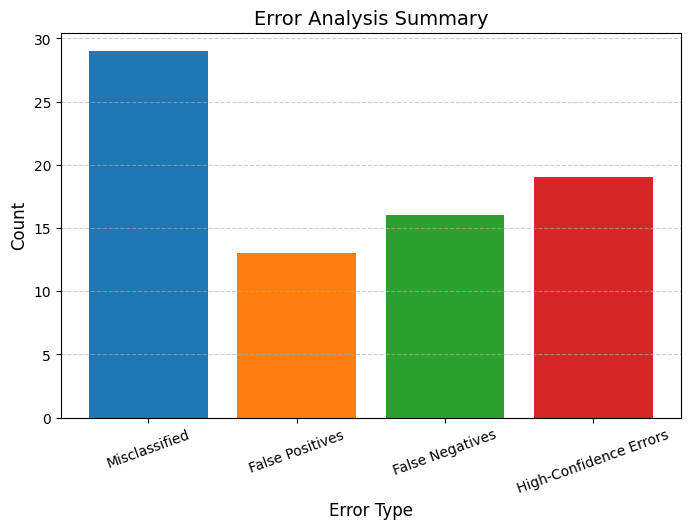

In [28]:
import matplotlib.pyplot as plt

counts = {
    "Misclassified": len(wrong_df),
    "False Positives": len(false_positives),
    "False Negatives": len(false_negatives),
    "High-Confidence Errors": len(high_conf_wrong)
}

plt.figure(figsize=(8,5))
plt.bar(counts.keys(), counts.values(), color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
plt.title("Error Analysis Summary", fontsize=14)
plt.xlabel("Error Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

**Sarcasm Dataset Loading & Cleaning**

Load the Reddit sarcasm dataset, keep only the text and label columns, normalize label values to binary (sarcastic vs non-sarcastic), remove invalid rows, and ensure labels are integers for model training.

In [29]:
# === Sarcasm dataset: load & clean ===
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')


sarc_csv_path  = "/content/drive/MyDrive/MS/1st Sem/NLP/Data/train-balanced-sarcasm.csv"
SARC_TEXT_COL  = "comment"
SARC_LABEL_COL = "label"

df_sarc = pd.read_csv(sarc_csv_path)

df_sarc = df_sarc[[SARC_TEXT_COL, SARC_LABEL_COL]].dropna()
df_sarc[SARC_TEXT_COL] = df_sarc[SARC_TEXT_COL].astype(str).str.strip()

if df_sarc[SARC_LABEL_COL].dtype == "object":
    sarc_map = {
        "sarcasm": 1,
        "sarcastic": 1,
        "not_sarcasm": 0,
        "non_sarcastic": 0,
        "normal": 0
    }
    df_sarc[SARC_LABEL_COL] = df_sarc[SARC_LABEL_COL].map(sarc_map)

df_sarc = df_sarc.dropna(subset=[SARC_LABEL_COL])
df_sarc[SARC_LABEL_COL] = df_sarc[SARC_LABEL_COL].astype(int)

print(df_sarc.head())
print(df_sarc[SARC_LABEL_COL].value_counts())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                             comment  label
0                                         NC and NH.      0
1  You do know west teams play against west teams...      0
2  They were underdogs earlier today, but since G...      0
3  This meme isn't funny none of the "new york ni...      0
4                    I could use one of those tools.      0
label
0    505403
1    505368
Name: count, dtype: int64


**Train–Test Split (Sarcasm Dataset)**

Split the sarcasm dataset into training (80%) and test (20%) sets using stratified sampling to preserve class balance across splits.

In [30]:
# === Train / test split for sarcasm ===
train_sarc_df, test_sarc_df = train_test_split(
    df_sarc[[SARC_TEXT_COL, SARC_LABEL_COL]],
    test_size=0.2,
    random_state=42,
    stratify=df_sarc[SARC_LABEL_COL]
)

len(train_sarc_df), len(test_sarc_df)

(808616, 202155)

### Sarcasm Dataset Tokenization (DistilBERT)

The sarcasm training and test splits are converted into Hugging Face `Dataset` objects and tokenized using the DistilBERT tokenizer.  
Text is truncated/padded to a fixed length (128 tokens), labels are renamed to `labels`, and datasets are formatted as PyTorch tensors for transformer fine-tuning.

In [31]:
# === Hugging Face Dataset + tokenization for sarcasm ===
from datasets import Dataset
from transformers import AutoTokenizer

sarc_model_name = "distilbert-base-uncased"
tokenizer_sarc = AutoTokenizer.from_pretrained(sarc_model_name)

train_sarc_ds = Dataset.from_pandas(train_sarc_df.reset_index(drop=True))
test_sarc_ds  = Dataset.from_pandas(test_sarc_df.reset_index(drop=True))

def tokenize_sarc(batch):
    return tokenizer_sarc(
        batch[SARC_TEXT_COL],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_sarc_ds = train_sarc_ds.map(tokenize_sarc, batched=True)
test_sarc_ds  = test_sarc_ds.map(tokenize_sarc, batched=True)

train_sarc_ds = train_sarc_ds.rename_column(SARC_LABEL_COL, "labels")
test_sarc_ds  = test_sarc_ds.rename_column(SARC_LABEL_COL, "labels")

for col in ["__index_level_0__", "index"]:
    if col in train_sarc_ds.column_names:
        train_sarc_ds = train_sarc_ds.remove_columns([col])
    if col in test_sarc_ds.column_names:
        test_sarc_ds = test_sarc_ds.remove_columns([col])

train_sarc_ds.set_format("torch")
test_sarc_ds.set_format("torch")

train_sarc_ds, test_sarc_ds

Map:   0%|          | 0/808616 [00:00<?, ? examples/s]

Map:   0%|          | 0/202155 [00:00<?, ? examples/s]

(Dataset({
     features: ['comment', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 808616
 }),
 Dataset({
     features: ['comment', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 202155
 }))

**Model + metrics + Trainer (sarcasm)**

Fine-tune DistilBERT for sarcasm: load DistilBERT sequence classifier, define macro metrics (accuracy/precision/recall/F1), set training args (3 epochs, LR=2e-5), and run Trainer on sarcasm train/test sets.

In [32]:
# === Model, metrics, Trainer for sarcasm ===
import numpy as np
!pip -q install transformers datasets accelerate evaluate
import evaluate
from transformers import (
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

num_labels_sarc = 2
model_sarc = AutoModelForSequenceClassification.from_pretrained(
    sarc_model_name,
    num_labels=num_labels_sarc
)

data_collator_sarc = DataCollatorWithPadding(tokenizer=tokenizer_sarc)

accuracy_metric  = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric    = evaluate.load("recall")
f1_metric        = evaluate.load("f1")

def compute_metrics_sarc(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(predictions=preds, references=labels)
    prec = precision_metric.compute(predictions=preds, references=labels, average="macro")
    rec = recall_metric.compute(predictions=preds, references=labels, average="macro")
    f1 = f1_metric.compute(predictions=preds, references=labels, average="macro")

    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1["f1"],
    }

training_args_sarc = TrainingArguments(
    output_dir="./distilbert-sarcasm",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer_sarc = Trainer(
    model=model_sarc,
    args=training_args_sarc,
    train_dataset=train_sarc_ds,
    eval_dataset=test_sarc_ds,
    tokenizer=tokenizer_sarc,
    data_collator=data_collator_sarc,
    compute_metrics=compute_metrics_sarc,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-491556923.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_sarc = Trainer(


In [33]:
# === Train sarcasm model ===
sarc_train_result = trainer_sarc.train()
trainer_sarc.save_model("./distilbert-sarcasm-best")

sarc_train_result.metrics

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.504500,0.478596,0.771458,0.774726,0.771456,0.770775
2,0.434900,0.485922,0.777305,0.778004,0.777304,0.777164


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.504500,0.478596,0.771458,0.774726,0.771456,0.770775
2,0.434900,0.485922,0.777305,0.778004,0.777304,0.777164
3,0.367100,0.516074,0.773144,0.773148,0.773144,0.773144


{'train_runtime': 13159.904,
 'train_samples_per_second': 184.336,
 'train_steps_per_second': 11.521,
 'total_flos': 8.033644352371507e+16,
 'train_loss': 0.435523803399355,
 'epoch': 3.0}

**Evaluate sarcasm classifier.**  
Report accuracy, precision, recall, F1-score, and visualize performance using a confusion matrix.

Sarcasm test metrics: {'test_loss': 0.4859215021133423, 'test_accuracy': 0.7773045435433207, 'test_precision': 0.7780038162853771, 'test_recall': 0.7773036750131792, 'test_f1': 0.7771640489826431, 'test_runtime': 339.1997, 'test_samples_per_second': 595.976, 'test_steps_per_second': 18.626}

Sarcasm classification report:

              precision    recall  f1-score   support

           0     0.7641    0.8024    0.7828    101081
           1     0.7919    0.7522    0.7716    101074

    accuracy                         0.7773    202155
   macro avg     0.7780    0.7773    0.7772    202155
weighted avg     0.7780    0.7773    0.7772    202155



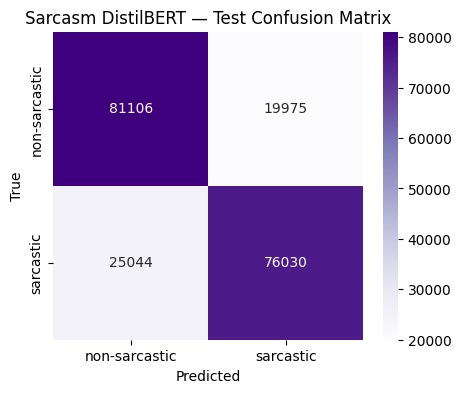

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sarc_pred_output = trainer_sarc.predict(test_sarc_ds)
sarc_logits = sarc_pred_output.predictions
sarc_y_true = sarc_pred_output.label_ids
sarc_y_pred = np.argmax(sarc_logits, axis=-1)

print("Sarcasm test metrics:", sarc_pred_output.metrics)
print("\nSarcasm classification report:\n")
print(classification_report(sarc_y_true, sarc_y_pred, digits=4))

cm_sarc = confusion_matrix(sarc_y_true, sarc_y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_sarc, annot=True, fmt="d", cmap="Purples",
            xticklabels=["non-sarcastic","sarcastic"],
            yticklabels=["non-sarcastic","sarcastic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Sarcasm DistilBERT — Test Confusion Matrix")
plt.show()

In [1]:
!pip -q install gradio

**Load Models for Demo**

Loads trained depression model, sets device, and prepares label mappings for inference.

In [2]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import gradio as gr
from google.colab import drive
drive.mount('/content/drive')


MODEL_DEP_DIR = "/content/drive/MyDrive/MS/1st Sem/NLP/Data/distilbert-depression-best"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dep_tokenizer = AutoTokenizer.from_pretrained(MODEL_DEP_DIR)
dep_model = AutoModelForSequenceClassification.from_pretrained(MODEL_DEP_DIR)
dep_model.to(device)
dep_model.eval()

dep_id2label = {0: "non-depressed", 1: "depressed"}

Mounted at /content/drive


**Depression Inference Function**

Defines a helper function that takes raw text, tokenizes it using the DistilBERT tokenizer, runs the fine-tuned depression model, and returns the predicted label (`depressed` / `non-depressed`) along with a confidence score.

In [3]:
def classify_depression(text: str):
    text = text.strip()
    if not text:
        return "Please enter some text.", 0.0

    enc = dep_tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    with torch.no_grad():
        logits = dep_model(input_ids, attention_mask=attention_mask).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

    pred_id = int(np.argmax(probs))
    pred_label = dep_id2label[pred_id]
    confidence = float(probs[pred_id])
    return pred_label, round(confidence, 4)

**Load fine-tuned sarcasm model**


Loads the trained DistilBERT sarcasm classifier and tokenizer, moves the model to the available device (CPU/GPU), and sets it to evaluation mode. A label mapping is defined for readable predictions (sarcastic vs non-sarcastic).

In [4]:
MODEL_SARC_DIR = "/content/drive/MyDrive/MS/1st Sem/NLP/Data/distilbert-sarcasm-best"

sarc_tokenizer = AutoTokenizer.from_pretrained(MODEL_SARC_DIR)
sarc_model = AutoModelForSequenceClassification.from_pretrained(MODEL_SARC_DIR)
sarc_model.to(device)
sarc_model.eval()

# assuming 0 = non-sarcastic, 1 = sarcastic
sarc_id2label = {0: "non-sarcastic", 1: "sarcastic"}

**Sarcasm Prediction Function**

Define a helper function that predicts whether a given text is sarcastic and returns the label with confidence.


In [5]:
def classify_sarcasm(text: str):
    text = text.strip()
    if not text:
        return "Please enter some text.", 0.0

    enc = sarc_tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    with torch.no_grad():
        logits = sarc_model(input_ids, attention_mask=attention_mask).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

    pred_id = int(np.argmax(probs))
    pred_label = sarc_id2label[pred_id]
    confidence = float(probs[pred_id])
    return pred_label, round(confidence, 4)

**Combined Analysis & Interpretation**

Runs both the depression and sarcasm classifiers on the input text and combines their outputs.  
Uses simple rules to interpret confidence scores and flag cases where sarcasm may reduce the reliability of the depression prediction.

In [6]:
def analyze_post(text: str):
    text = text.strip()
    if not text:
        return (
            "—",
            0.0,
            "—",
            0.0,
            "Please enter some text above to get a prediction.",
        )

    dep_label, dep_conf = classify_depression(text)
    sarc_label, sarc_conf = classify_sarcasm(text)

    # Simple interpretation logic
    msg_lines = []
    msg_lines.append(f"- **Depression model**: `{dep_label}` (confidence ≈ {dep_conf:.2f})")
    msg_lines.append(f"- **Sarcasm model**: `{sarc_label}` (confidence ≈ {sarc_conf:.2f})")

    # A few informal rules
    if dep_label == "depressed" and dep_conf > 0.75 and sarc_conf < 0.6:
        msg_lines.append(
            "\n⚠️ Model sees this as **likely depressed** and not strongly sarcastic. "
            "In a real system this would deserve attention."
        )
    elif dep_label == "depressed" and sarc_conf >= 0.6:
        msg_lines.append(
            "\n🤔 Model thinks the content is **depressed**, but also **highly sarcastic**. "
            "The emotional signal might be ironic or playful, so this prediction should be treated with caution."
        )
    elif dep_label == "non-depressed" and sarc_conf >= 0.6:
        msg_lines.append(
            "\n🙂 Overall tone looks **non-depressed**, but sarcasm is high – "
            "this could be playful joking rather than genuine distress."
        )
    else:
        msg_lines.append(
            "\n✅ Model sees this as **non-depressed** with low sarcasm. "
            "Tone looks mostly neutral or positive."
        )

    interpretation = "\n".join(msg_lines)
    return dep_label, round(dep_conf, 4), sarc_label, round(sarc_conf, 4), interpretation

**Gradio Web Demo (Depression + Sarcasm)**

Builds an interactive Gradio interface where users can input Reddit-style text and receive:

Depression prediction + confidence

Sarcasm prediction + confidence

Includes example inputs, clear visual outputs, and an explanation section emphasizing research-only usage (not clinical)

In [7]:
theme = gr.themes.Soft(primary_hue="orange", neutral_hue="slate")

with gr.Blocks(theme=theme) as demo:
    gr.Markdown(
        """
# Reddit Depression + Sarcasm Classifier

Demo of DistilBERT **depression classifier** plus a separate **sarcasm detector**.

- Depression model output: `depressed` vs `non-depressed`
- Sarcasm model output: `sarcastic` vs `non-sarcastic`
- Interpretation combines both scores.

⚠️ **Research prototype only – not a clinical or diagnostic tool.**
        """
    )

    with gr.Row():
        # Left: input + examples
        with gr.Column(scale=1):
            txt = gr.Textbox(
                lines=7,
                label="Reddit post / text",
                placeholder="Paste a Reddit-style post here…",
            )

            gr.Examples(
                examples=[
                    ["I’m so done with life, nothing feels worth it anymore."],
                    ["Had a great day at work, feeling proud of myself!"],
                    ["Yeah, everything is *totally* fine while I cry myself to sleep 😂"],
                    ["Another Monday, another meeting… living the dream 🙃"],
                ],
                inputs=txt,
            )

        # Right: outputs
        with gr.Column(scale=1):
            gr.Markdown("### 🔍 Model predictions")

            with gr.Row():
                dep_label_out = gr.Label(label="Depression prediction")
                sarc_label_out = gr.Label(label="Sarcasm prediction")

            with gr.Row():
                dep_conf_out = gr.Slider(
                    0, 1, value=0, step=0.01, interactive=False,
                    label="Depression confidence (0–1)"
                )
                sarc_conf_out = gr.Slider(
                    0, 1, value=0, step=0.01, interactive=False,
                    label="Sarcasm confidence (0–1)"
                )

            #gr.Markdown("### 🧠 Combined interpretation")
            #interp_md = gr.Markdown(value="Model explanation will appear here.")

            with gr.Row():
                btn_run = gr.Button("Submit", variant="primary")
                btn_clear = gr.Button("Clear")

    # Info / how-to section
    with gr.Accordion("How to read these scores", open=False):
        gr.Markdown(
            """
- **Confidence** is the model's probability for the predicted label.
- High depression score + low sarcasm score → more reliable depression signal.
- High depression score + high sarcasm score → text might be joking/ironic.
- This app is meant to explore model behavior, **not** to make clinical decisions.
            """
        )

    # Wire buttons
    btn_run.click(
        analyze_post,
        inputs=txt,
        outputs=[dep_label_out, dep_conf_out, sarc_label_out, sarc_conf_out],
    )

    def clear_all():
        return "", "—", 0.0, "—", 0.0, "Cleared. Enter new text above."

    btn_clear.click(
        clear_all,
        inputs=None,
        outputs=[txt, dep_label_out, dep_conf_out, sarc_label_out, sarc_conf_out],
    )

demo.launch(share=True)

/tmp/ipython-input-3091284992.py:3: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=theme) as demo:


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://821159c1c089ed795b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
